In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, griddata
import imageio
import os
from numba import jit

# 1 Чтение большого CSV файла
def read_large_csv(file_path, chunksize=1000):
    """Читает большой CSV файл по частям и возвращает объединённый DataFrame."""
    chunks = []
    for chunk in pd.read_csv(file_path, sep=';', chunksize=chunksize):
        chunks.append(chunk)
    return pd.concat(chunks, ignore_index=True)

# 2 Визуализация данных для конкретного ti

def visualize_for_ti(df1, df2, ti, output_dir='plots'):
    """Визуализирует данные u(x) для заданного ti для двух наборов данных, с интерполяцией при необходимости."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Функция для получения данных для заданного ti
    def get_data_for_ti(df, ti):
        if ti in df['t'].unique():
            return df[df['t'] == ti]
        else:
            x_unique = df['x'].unique()
            u_interp = []
            for x in x_unique:
                data_x = df[df['x'] == x]
                if len(data_x) > 1:
                    f = interp1d(data_x['t'], data_x['u'], kind='cubic', fill_value="extrapolate")
                    u_interp.append(f(ti))
                else:
                    u_interp.append(np.nan)
            return pd.DataFrame({'x': x_unique, 'u': u_interp})

    # Получаем данные для обоих наборов
    data1 = get_data_for_ti(df1, ti)
    data2 = get_data_for_ti(df2, ti)


    plt.figure()
    plt.plot(data1['x'], data1['u'], 'b-', label='Implicit')
    plt.plot(data2['x'], data2['u'], 'r--', label='Explicit')
    plt.ylim(0, 4)
    plt.grid()
    plt.xlabel(r'$x/\delta$')
    plt.ylabel('u')
    plt.title(f'CFD Data at t = {ti}')
    plt.legend()
    plot_path = os.path.join(output_dir, f'plot_t_{ti}.png')
    plt.savefig(plot_path)
    plt.close()
    return plot_path

# 3. Построение GIF анимации
def create_gif(df1, df2, tau, num_frames=100, output_gif='s_num.gif'):
    """Создаёт GIF анимацию для интервала [0, tau] для двух наборов данных."""
    times = np.linspace(0, tau, num_frames)
    images = []
    for ti in times:
        plot_path = visualize_for_ti(df1, df2, ti)
        images.append(imageio.imread(plot_path))

    imageio.mimsave(output_gif, images, duration=0.05)  # Сохраняем GIF с длительностью кадра 0.1 сек

def auto_build(df1, df2):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Построение точечного графика u от eta
    #ax.plot(df1['eta'], df1['u'], 'b-', label='Analytic')
    ax.scatter(df2['eta'], df2['u'], s=1, label='Numeric')

    # Настройка подписей осей и заголовка
    ax.set_xlabel(r'$\eta = \frac{x}{\sqrt{t}}$', fontsize=14)
    ax.set_ylabel(r'$u$', fontsize=14)
    ax.set_title('Зависимость скорости в автомодельных координатах', fontsize=16)

    # Добавление major и minor gridlines
    ax.grid(which='major', linestyle='-', linewidth=0.5, color='black')
    ax.grid(which='minor', linestyle=':', linewidth=0.5, color='gray')
    ax.minorticks_on()

    # Отображение графика
    fig.savefig('Auto.png')
    fig.show()


def get_interpolated_value(df, x_target, t_target, method='linear'):
    # Проверка точного совпадения
    exact_match = df[(df['x'] == x_target) & (df['t'] == t_target)]
    if not exact_match.empty:
        return exact_match['u'].values[0], 'NORM'

    # Подготовка данных для интерполяции
    points = df[['x', 't']].values
    values = df['u'].values
    target = np.array([[x_target, t_target]])

    # Интерполяция выбранным методом
    interpolated = griddata(points, values, target, method=method)

    # Если результат NaN, пробуем метод nearest
    if np.isnan(interpolated):
        interpolated = griddata(points, values, target, method='nearest')

    return interpolated[0]
if __name__ == "__main__":
    #delta = np.sqrt(2)
    file_path1 = 'prim_IMP.csv' #IMPLICIT
    #file_path2 = 'prim_EXP.csv' #EXPLICIT
    df1 = read_large_csv(file_path1)
    #df2 = read_large_csv(file_path2)
    #df1['x'] = df1['x']/delta
    #df2['x'] = df2['x']/delta
    create_gif(df1, df1, tau=3, output_gif='prim.gif')
    #get_interpolated_value(df2, 3, 5, method='linear')
    #visualize_for_ti(df1, df2, 0, output_dir='my')
    #auto_build(df1, df2))

C:\Users\huawei\AppData\Local\Temp\ipykernel_16932\3392845067.py:66: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(plot_path))


In [ ]:
df1 = read_large_csv('res2_exp_05.csv')
df2 = read_large_csv('res2_exp_1.csv')
df3 = read_large_csv('res2_exp_101.csv')

print(get_interpolated_value(df1, 3, 5, method='linear'))
print(get_interpolated_value(df1, 10, 5, method='linear'))

In [ ]:
#Явная. Шаг по времени
c1 = [0.5, 1] #C
y_05_3_1 = [0.222, 0.785] #X=3
y_05_6_1 = [0.803, 2.003] #X=6

#Неявная шаг по времени
c2 = [0.5, 1, 2]
y_05_3_2 = [1.182, 3.778, 14.457] #X=3
y_05_6_2 = [5.512, 30.07, 122.5] #X=6

#Явная шаг по координате
n3 = [20, 40, 80]
y_05_3_3 = [7.9, 1.957, 0.266] #X=3
y_05_6_3 = [45.207, 12.118, 3.266] #X=6

#Неявная шаг по координате
y_05_3_4 = [8.314, 2.256, 0.557] #X=3
y_05_6_4 = [42.588, 11.756, 3.783] #X=6

In [ ]:

from matplotlib.ticker import AutoMinorLocator

# Инициализация графики
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# Настройка стилей сетки
major_grid_style = {'linestyle': '-', 'linewidth': 0.7, 'alpha': 0.6, 'color': 'gray'}
minor_grid_style = {'linestyle': ':', 'linewidth': 0.5, 'alpha': 0.4, 'color': 'lightgray'}

# График 1: Явная схема (шаг по времени)
ax = axs[0, 0]
ax.plot(c1, y_05_3_1, 'o', markersize=8, label='X=3')
ax.plot(c1, y_05_6_1, 's', markersize=8, label='X=6')
ax.set_title('Явная. Шаг по времени', fontsize=12)
ax.set_xlabel('C', fontsize=10)
ax.set_ylabel('Error (t=0.5)', fontsize=10)
ax.legend()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(True, which='major', **major_grid_style)
ax.grid(True, which='minor', **minor_grid_style)

# График 2: Неявная схема (шаг по времени)
ax = axs[0, 1]
ax.plot(c2, y_05_3_2, 'o', markersize=8, label='X=3')
ax.plot(c2, y_05_6_2, 's', markersize=8, label='X=6')
ax.set_title('Неявная. Шаг по времени', fontsize=12)
ax.set_xlabel('C', fontsize=10)
ax.set_ylabel('Error(t=10)', fontsize=10)
ax.legend()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(True, which='major', **major_grid_style)
ax.grid(True, which='minor', **minor_grid_style)

# График 3: Явная схема (шаг по координате)
ax = axs[1, 0]
ax.plot(n3, y_05_3_3, 'o', markersize=8, label='X=3')
ax.plot(n3, y_05_6_3, 's', markersize=8, label='X=6')
ax.set_title('Явная. Шаг по координате', fontsize=12)
ax.set_xlabel('N', fontsize=10)
ax.set_ylabel('Error (t=10)', fontsize=10)
ax.legend()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(True, which='major', **major_grid_style)
ax.grid(True, which='minor', **minor_grid_style)

# График 4: Неявная схема (шаг по координате)
ax = axs[1, 1]
ax.plot(n3, y_05_3_4, 'o', markersize=8, label='X=3')
ax.plot(n3, y_05_6_4, 's', markersize=8, label='X=6')
ax.set_title('Неявная. Шаг по координате', fontsize=12)
ax.set_xlabel('N', fontsize=10)
ax.set_ylabel('Error (t=10)', fontsize=10)
ax.legend()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(True, which='major', **major_grid_style)
ax.grid(True, which='minor', **minor_grid_style)

fig.savefig('Graphs.PNG', dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()

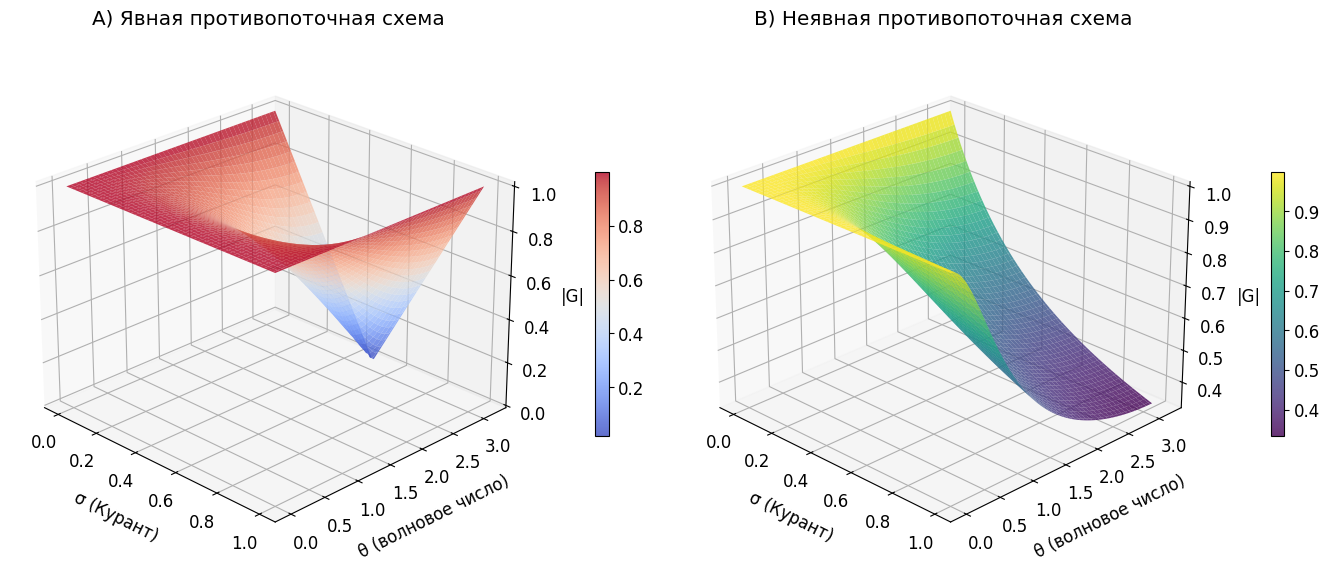

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Параметры сетки
sigma = np.linspace(0, 1, 100)        # Число Куранта
theta = np.linspace(0, np.pi, 100)   # Безразмерное волновое число
sigma_grid, theta_grid = np.meshgrid(sigma, theta)

# Вычисление модуля коэффициента перехода
def calculate_G(scheme_type):
    if scheme_type == "explicit":
        return np.sqrt(1 - 2*sigma_grid + 2*sigma_grid**2 + 2*sigma_grid*(1 - sigma_grid)*np.cos(theta_grid))
    elif scheme_type == "implicit":
        return 1 / np.sqrt(1 + 2*sigma_grid + 2*sigma_grid**2 - 2*sigma_grid*(1 + sigma_grid)*np.cos(theta_grid))

G_explicit = calculate_G("explicit")
G_implicit = calculate_G("implicit")

# Настройка графики
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(14, 6))

# Явная схема
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(
    sigma_grid,
    theta_grid,
    G_explicit,
    cmap='coolwarm',
    rstride=2,
    cstride=2,
    alpha=0.8
)
ax1.set_title('A) Явная противопоточная схема', pad=15)
ax1.set_xlabel('σ (Курант)', labelpad=10)
ax1.set_ylabel('θ (волновое число)', labelpad=10)
ax1.set_zlabel('|G|', labelpad=5)
ax1.view_init(elev=25, azim=-45)

# Неявная схема
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(
    sigma_grid,
    theta_grid,
    G_implicit,
    cmap='viridis',
    rstride=2,
    cstride=2,
    alpha=0.8
)
ax2.set_title('B) Неявная противопоточная схема', pad=15)
ax2.set_xlabel('σ (Курант)', labelpad=10)
ax2.set_ylabel('θ (волновое число)', labelpad=10)
ax2.set_zlabel('|G|', labelpad=5)
ax2.view_init(elev=25, azim=-45)

# Общие настройки
plt.tight_layout()
fig.colorbar(surf1, ax=ax1, shrink=0.5, pad=0.1)
fig.colorbar(surf2, ax=ax2, shrink=0.5, pad=0.1)
plt.show()

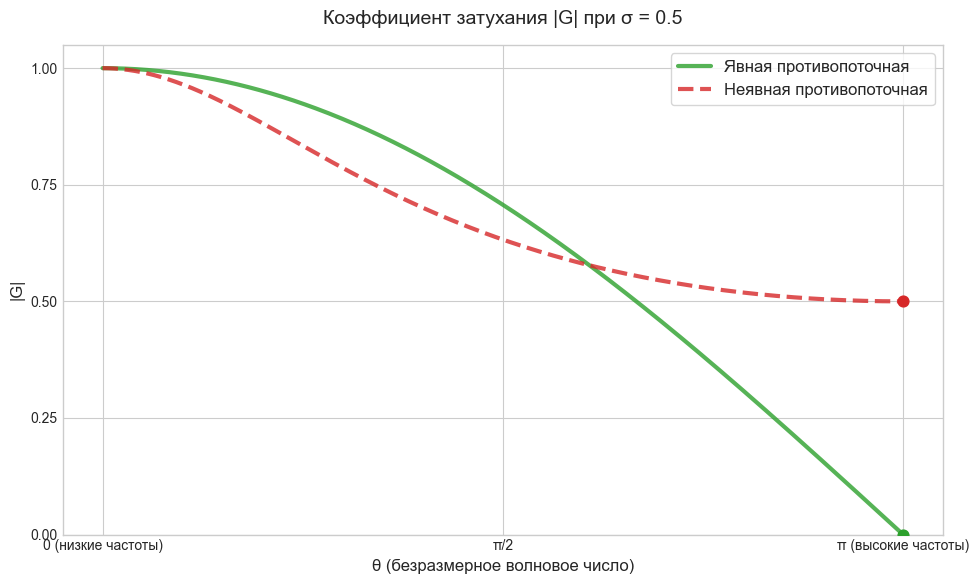

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры
theta = np.linspace(0, np.pi, 500)  # Волновое число θ ∈ [0, π]
sigma = 0.5  # Фиксированное число Куранта

# Вычисление коэффициентов затухания
G_explicit = np.sqrt(0.5 * (1 + np.cos(theta)))  # Явная схема
G_implicit = 1 / np.sqrt(2.5 - 1.5 * np.cos(theta))  # Неявная схема

# Настройка стиля
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(10, 6))

# Построение графиков
plt.plot(theta, G_explicit,
         label="Явная противопоточная",
         color="#2ca02c",
         linewidth=3,
         alpha=0.8)

plt.plot(theta, G_implicit,
         label="Неявная противопоточная",
         color="#d62728",
         linestyle="--",
         linewidth=3,
         alpha=0.8)

# Настройка осей и легенды
plt.title("Коэффициент затухания |G| при σ = 0.5", fontsize=14, pad=15)
plt.xlabel("θ (безразмерное волновое число)", fontsize=12)
plt.ylabel("|G|", fontsize=12)
plt.xticks(
    [0, np.pi/2, np.pi],
    ["0 (низкие частоты)", "π/2", "π (высокие частоты)"],
    fontsize=10
)
plt.yticks(np.linspace(0, 1, 5), fontsize=10)
plt.ylim(0, 1.05)
plt.legend(loc="upper right", fontsize=12, frameon=True)

# Выделение ключевых точек
plt.scatter([np.pi], [0], color="#2ca02c", zorder=3, s=60)
plt.scatter([np.pi], [0.5], color="#d62728", zorder=3, s=60)

# Добавление пояснений
#plt.text(np.pi-0.3, 0.05, "Полное затухание\nявной схемы",
#         ha="right", va="bottom", fontsize=10)
#plt.text(np.pi-0.3, 0.52, "50% затухание\nнеявной схемы",
#        ha="right", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()